# Visualisation of the MIMIC data using t-SNE

For a background on t-Distributed Stochastic Neighbor Embedding (t-SNE), see Laurens van der Maaten's blog: https://lvdmaaten.github.io/tsne/


In [14]:
# config
# for speed, run on a subset of 5000 patient
run_on_subset = False
# should the proportion of each class be equalized?
balanceclasses = True 

In [15]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import psycopg2
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [2]:
# display TSNE documentation
help(TSNE)

Help on class TSNE in module sklearn.manifold.t_sne:

class TSNE(sklearn.base.BaseEstimator)
 |  t-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimensionality reduction
 |  method (e.g. PCA for dense data or TruncatedSVD for sparse data)
 |  to reduce the number of dimensions to a reasonable amount (e.g. 50)
 |  if the number of features is very high. This will suppress some
 |  noise and speed up the computation of pairwise distances between
 |  samples. For more tips see Laurens van der Maaten's FAQ [2].
 |  
 |  Parameters
 |  --

In [16]:
# Connect to MIMIC
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
# cur.close()
# con.close()

In [17]:
query = """
WITH firstvals as (
    SELECT rank() OVER (PARTITION BY vi.subject_id ORDER BY ic.intime ASC) as icuorder,
    vi.*, ic.intime, di.icd9_code, dd.short_title, ic.los_icu, ic.hospital_expire_flag,
    ic.los_hospital, ic.age, ic.gender, an.angus,
    el.congestive_heart_failure, el.cardiac_arrhythmias,el.valvular_disease,el.pulmonary_circulation,
    el.peripheral_vascular,el.hypertension,el.paralysis,el.other_neurological,el.chronic_pulmonary,
    el.diabetes_uncomplicated,el.diabetes_complicated,el.hypothyroidism,el.renal_failure,el.liver_disease,
    el.peptic_ulcer,el.aids,el.lymphoma,el.metastatic_cancer,el.solid_tumor,el.rheumatoid_arthritis,
    el.coagulopathy,el.obesity,el.weight_loss,el.fluid_electrolyte,el.blood_loss_anemia,
    el.deficiency_anemias,el.alcohol_abuse,el.drug_abuse,el.psychoses,el.depression
    FROM vitalsfirstday vi
    INNER JOIN diagnoses_icd di
    ON vi.hadm_id = di.hadm_id
    INNER JOIN d_icd_diagnoses dd
    ON di.icd9_code = dd.icd9_code
    INNER JOIN icustay_detail ic
    ON vi.icustay_id = ic.icustay_id
    INNER JOIN elixhauser_ahrq el
    ON vi.hadm_id = el.hadm_id
    INNER JOIN angus_sepsis an
    ON vi.hadm_id = an.hadm_id 
    WHERE di.seq_num = 1
    ORDER BY vi.subject_id)
SELECT *
FROM firstvals
WHERE icuorder = 1
AND age >=16
AND los_icu >=1
"""

phys = pd.read_sql_query(query,con)

In [18]:
# Encode
# Encode gender
phys['gender'] = pd.factorize(phys['gender'])[0]
phys['icd9_code_enc'] = pd.factorize(phys['icd9_code'])[0]

In [19]:
# Limit the dataset for speed
if run_on_subset:
    n_to_compute=5000
    phys = phys[:]

In [20]:
# vars of interest
# add age and gender

# physvars = ['heartrate_min', 'heartrate_max', 'sysbp_min', 'sysbp_max', 'diasbp_min', 'diasbp_max', 'meanbp_min', 
#             'meanbp_max', 'resprate_min', 'resprate_max', 'tempc_min', 'tempc_max', 'spo2_min', 'spo2_max', 
#             'glucose_min', 'glucose_max']

# physvars = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean', 
#             'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean'] 

physvars = ['heartrate_min', 'heartrate_max', 'sysbp_min', 'sysbp_max', 'diasbp_min', 'diasbp_max', 'meanbp_min', 
            'meanbp_max', 'resprate_min', 'resprate_max', 'tempc_min', 'tempc_max', 'spo2_min', 'spo2_max', 
            'glucose_min', 'glucose_max', 'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean', 
            'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean'] 

# remove rows with nan
phys.dropna(inplace=True)

In [21]:
# Scale columns with zero mean and unit variance
phys[physvars] = MinMaxScaler().fit_transform(phys[physvars])

In [22]:
# define label for colouring plot
# phys['label']=phys.gender
# phys['label']=phys.weight_loss*6
# phys['label']=phys.angus*6
phys['label']=phys.hospital_expire_flag*6
# phys['label']=pd.qcut(phys.los_hospital,11,labels=range(1,12))
# phys['label']=pd.qcut(phys.los_icu,8,labels=range(0,8))
# phys['label']=pd.qcut(phys.icd9_code_enc,9,labels=range(0,9))
# phys['label']=pd.qcut(phys.age,10,labels=range(0,10))

In [24]:
# balance selection of classes with weight vector
if balanceclasses:
    labelcount=phys.label.value_counts(normalize=True)
    phys['labelweight']=np.ones(len(phys))
    for la,wt in labelcount.iteritems():
        phys.loc[phys.label==la,'labelweight'] = 1-wt
    # get sample approx equal classes
    totalnum=phys.label.value_counts().min()*phys.label.nunique()
    # replace=True will lead to closer sample size but with replacement
    phys = phys.sample(n=totalnum, replace=False, weights=phys.labelweight)
    print('Class numbers balanced')
print('Number of classes: {}'.format(phys.label.nunique()))
print('Number of samples: {}'.format(phys.label.count()))

Class numbers balanced
Number of classes: 2
Number of samples: 5684


In [25]:
# run the tsne
X_tsne = TSNE(learning_rate=1000).fit_transform(phys[physvars].values)

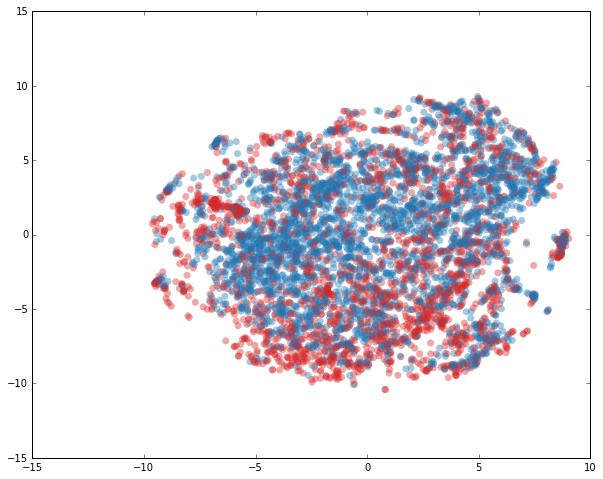

In [26]:
# set colours for plot
# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

# plot
plt.figure(figsize=(10, 8))
col = np.array(tableau20)[[phys.label]]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
            facecolor=col, edgecolor='None', marker='o', s=50,
            alpha=0.4)